In [4]:
import numpy as np
a = np.arange(60).reshape(12,5)
print(a)
print(np.argmax(a))
print(np.argmax(a, axis=0)) ## maximum row id along the columns
print(np.argmax(a, axis=1)) ## maximum column id along the rows

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]
 [30 31 32 33 34]
 [35 36 37 38 39]
 [40 41 42 43 44]
 [45 46 47 48 49]
 [50 51 52 53 54]
 [55 56 57 58 59]]
59
[11 11 11 11 11]
[4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
import splitfolders
splitfolders.ratio("Original", output="Split", seed=131, ratio=(.8,.2)) ## randomly split files along with folder structure

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect CT to be upside-down so we will not flip vertically

datagen_test = ImageDataGenerator(samplewise_center=True) # set each sample mean to 0

## remember to pre-process the image used for "prediction" the same way as images were pre-processed for training/validation
## since I missed it earlier, my validation score was very good but predictions terrible. I had missed the samplewise_center=True.
## this is a true pre-processing step.
## the others like rotation etc. are for augmentation. so it should not be used on a predicting image. 

## the datagen DOES NOT provide original images.. It REPLACES every input with the random transformation
## it DOES NOT provide additional images than original dataset either

In [15]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('/home/jupyter/data/Original/train/', 
                                       target_size=(128, 128), 
                                       color_mode='rgb', 
                                       class_mode='categorical', 
                                       batch_size=32,
                                       shuffle=True,
                                       seed=101)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('/home/jupyter/data/Original/valid', 
                                      target_size=(128, 128), 
                                      color_mode='rgb', 
                                      class_mode='categorical', 
                                      batch_size=100,
                                      shuffle=True,
                                      seed = 101)

# load and iterate test dataset
test_it = datagen_test.flow_from_directory('/home/jupyter/data/Original/test', 
                                      target_size=(128, 128), 
                                      color_mode='rgb', 
                                      class_mode='categorical', ## this still has to be given since evaluate actually compares with actual
                                      batch_size=1)

# load and iterate test dataset
test_one = datagen_test.flow_from_directory('/home/jupyter/data/Original/test_one', 
                                      target_size=(128, 128), 
                                      color_mode='rgb', 
                                      class_mode=None,  ## for prediction this is like totally unseen.. we don't know the actual
                                      shuffle=False, ## this is to match test_one.filenames[i] = predictions[i]; else predictions will return random orders everytime      
                                      batch_size=1)

## V.IMP there has to be atleast ONE sub-folder inside the test_one. doesn't have to be named after classes or have any relation.
## because then it will be 1 class or it will be like 0 class.. see below result.. found 1 image belonging to 1 class

## remove the hidden .ipynb_checkpoints folder if it identifies extra 1 class in a folder
## ls -a
## rmdir .ipynb_checkpoints/

Found 15747 images belonging to 3 classes.
Found 3938 images belonging to 3 classes.
Found 329 images belonging to 3 classes.
Found 29 images belonging to 1 classes.


In [3]:
labels = (train_it.class_indices)
labels

{'NiCT': 0, 'nCT': 1, 'pCT': 2}

In [4]:
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'NiCT', 1: 'nCT', 2: 'pCT'}

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Dropout,
    Flatten,
    BatchNormalization,
    GlobalAveragePooling2D,
    MaxPool2D
)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation="relu", input_shape = (128, 128, 3)))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dropout(0.2))
#model.add(GlobalAveragePooling2D())
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=3, activation="softmax"))

## lower resolution 128, 128 actually worked better than 256,256... dont overburden the model
## model can see better than human eyes.. start low and then increase nodes, layers only if necessary

In [6]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 256)       2

In [8]:
# steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator. (this is best rule)
# validation_data=(x_valid, y_valid)) # if needed even valid data can be passed through the datagen.
# validation steps also use same logic, although it is not clear 
# when using datagens for any iterator the #steps have to be explicitly defined for it.
## too many epochs can overfit

model.fit(train_it, steps_per_epoch=492, validation_data=valid_it, validation_steps=39, epochs=10, workers=4)

Epoch 1/10
492/492 [==============================] - 117s 237ms/step - loss: 33.0369 - accuracy: 0.7279 - val_loss: 0.3060 - val_accuracy: 0.8767
Epoch 2/10
492/492 [==============================] - 105s 213ms/step - loss: 0.3261 - accuracy: 0.8776 - val_loss: 0.3168 - val_accuracy: 0.9064
Epoch 3/10
492/492 [==============================] - 104s 211ms/step - loss: 0.2712 - accuracy: 0.9119 - val_loss: 0.1580 - val_accuracy: 0.9449
Epoch 4/10
492/492 [==============================] - 105s 213ms/step - loss: 0.2391 - accuracy: 0.9239 - val_loss: 0.2229 - val_accuracy: 0.9264
Epoch 5/10
492/492 [==============================] - 105s 213ms/step - loss: 0.2438 - accuracy: 0.9301 - val_loss: 0.2083 - val_accuracy: 0.9300
Epoch 6/10
492/492 [==============================] - 104s 212ms/step - loss: 0.2747 - accuracy: 0.9252 - val_loss: 0.1213 - val_accuracy: 0.9523
Epoch 7/10
492/492 [==============================] - 104s 212ms/step - loss: 0.2744 - accuracy: 0.9247 - val_loss: 0.1610 

In [9]:
history = model.history

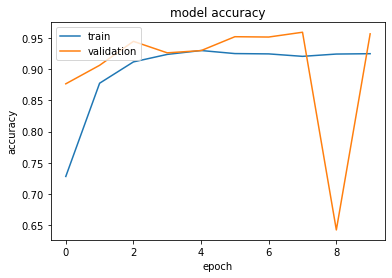

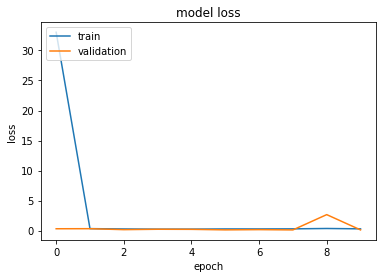

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
model.save('ctscan_original_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ctscan_original_model/assets


In [11]:
from tensorflow import keras
model = keras.models.load_model('ctscan_original_model')

In [12]:
model.evaluate(test_it) 

## remember to run the datagen flow i.e train_it, test_it etc. before predictions. 
## it reads the files then. basically reset if anything changed in the input.

329/329 [==============================] - 3s 10ms/step - loss: 0.0573 - accuracy: 0.9757


[0.05727984011173248, 0.975683867931366]

In [22]:
# when only one file is present
print(test_one.samples)
predictions = model.predict(test_one)
print(predictions)
print('Predicted Class:', labels[np.argmax(predictions)])

1
[[6.6490977e-31 1.2045882e-16 1.0000000e+00]]
Predicted Class: pCT


In [16]:
## GENERIC prediction: when more than 1 file were present
## pCT000 is actually a NiCT file..just to see how it predicts it was renamed!!
print('# of files', test_one.samples)
predictions = model.predict(test_one) ## one by one predicts all the files..the shuffle will make the order random, so shuffle=False in datagen
print(predictions)
for i in range(test_one.samples):
    print(test_one.filenames[i], 'predicted:', labels[np.argmax(predictions[i])])

# of files 29
[[9.5390999e-01 4.6089921e-02 5.9403977e-08]
 [1.0000000e+00 2.5916618e-11 1.1091565e-22]
 [4.7027401e-15 1.0000000e+00 3.1205694e-08]
 [4.0763698e-10 9.9999952e-01 5.0912104e-07]
 [6.4760065e-01 3.5239938e-01 8.1990281e-10]
 [9.1927453e-22 1.0000000e+00 4.9190502e-10]
 [1.4062233e-12 1.0000000e+00 8.0804002e-11]
 [8.0872846e-09 9.9998653e-01 1.3498362e-05]
 [1.4403537e-12 1.0000000e+00 7.0776420e-09]
 [6.7445099e-24 1.0000000e+00 8.0956354e-20]
 [4.4999021e-10 1.0000000e+00 3.4410166e-12]
 [2.3722947e-08 9.9995494e-01 4.5094625e-05]
 [1.7836435e-13 1.0000000e+00 5.3355731e-08]
 [1.0000000e+00 4.1373309e-09 3.7110768e-21]
 [3.5110984e-10 3.9843319e-05 9.9996018e-01]
 [4.0090158e-09 1.8508648e-05 9.9998152e-01]
 [2.4955010e-05 3.8153445e-03 9.9615967e-01]
 [6.9193367e-05 4.3830597e-03 9.9554777e-01]
 [7.7022944e-04 7.3328479e-03 9.9189693e-01]
 [2.0012475e-04 2.2321071e-03 9.9756771e-01]
 [8.2391524e-01 4.7548320e-03 1.7132989e-01]
 [9.5020788e-08 1.6181018e-04 9.9983811e-

# only 2 predictions were wrong!! 

### Below visualisation not needed

In [92]:
from tensorflow.keras.preprocessing import image as image_utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict_ctscan(file_path, labels):
    
    # Show image
    image = mpimg.imread(file_path)
    print('Original image shape: ', mpimg.imread(file_path).shape)
    plt.imshow(image)
    
    # Load and scale image
    image = image_utils.load_img(file_path, color_mode="rgb", target_size=(256,256))
    
    # Convert to array
    image = image_utils.img_to_array(image)
    
    # Reshape image
    image = image.reshape(1,256,256,3)
    
    # Normalize image
    image = image / 255
    print('Processed image shape: ', image.shape)
    
    # Make prediction
    prediction = model.predict(image)
    print('Prediction:', prediction)
    print('Predicted Class:', labels[np.argmax(prediction)])
    prediction_class = labels[np.argmax(prediction)]
          
    return prediction_class   

Original image shape:  (512, 512, 3)
Processed image shape:  (1, 256, 256, 3)
Prediction: [[0.44771293 0.08652484 0.46576223]]
Predicted Class: pCT


'pCT'

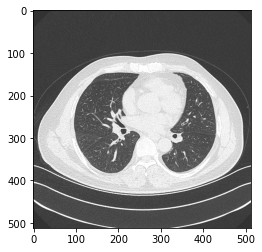

In [106]:
predict_ctscan('/home/jupyter/data/Original/valid/nCT/nCT1004.jpg', labels)

Original image shape:  (512, 512, 3)
Processed image shape:  (1, 256, 256, 3)
Prediction: [[0.4462552  0.08570689 0.4680379 ]]
Predicted Class: pCT


'pCT'

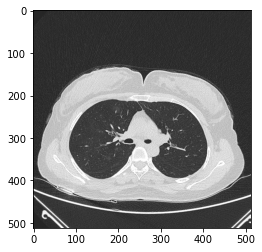

In [103]:
predict_ctscan('/home/jupyter/data/Original/train/nCT/nCT1008.jpg', labels)